In [12]:
from keras.metrics import mean_squared_error
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Constants
INPUT_FEATURES = 33  # Number of input features (e.g., temperature, humidity, etc.)
SEQUENCE_LENGTH = 7 * 24  # 7 days of hourly data
OUTPUT_FEATURES = 3 * 24  # Predicting 3 features for each of the 24 hours in the next day
LSTM_UNITS = 100  # Number of LSTM units
DENSE_UNITS = 50  # Number of Dense layer units
DROPOUT_RATE = 0.2  # Dropout rate

In [3]:
data = pd.read_csv('../preprocessing/krakow_data_17-23_preprocessed.csv')
data = data.drop('timestamp', axis=1)
data

,Temperatura powietrza [°C]/1,Ciśnienie na pozimie stacji [hPa],Opad za 6 godzin [mm],Wysokość podstawy niższej [m],Wysokość podstawy wyższej [m],Widzialność [kod],Widzialność operatora [m],Zachmurzenie ogólne [oktanty],Kierunek wiatru [°],Prędkość wiatru [m/s],...,Wystąpienie rosy [0/1],Poryw maksymalny za okres WW [m/s],Temperatura minimalna za 12 godzin [°C],Temperatura maksymalna za 12 godzin [°C],Równoważnik wodny śniegu [mm/cm],Wysokość pokrywy śnieżnej [cm],Wysokość świeżo spadłego śniegu [cm],Wysokość śniegu na poletku [cm],Wysokość próbki [cm],Ciężar próbki [g]
0,-6.8,995.8,0.0,0,0,5,3500,0,357,1,...,0,0,0.0,0.0,0.0,0,0,0,0,0
1,-6.9,995.6,0.0,0,0,5,3500,0,98,1,...,0,0,0.0,0.0,0.0,0,0,0,0,0
2,-3.9,994.9,0.0,0,0,6,5000,0,205,3,...,0,0,0.0,0.0,0.0,0,0,0,0,0
3,-6.5,994.1,0.0,0,0,6,4000,0,211,2,...,0,0,0.0,0.0,0.0,0,0,0,0,0
4,-6.1,993.6,0.0,0,0,6,4000,0,168,1,...,0,0,0.0,0.0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,8.3,991.2,0.0,0,0,8,20000,7,250,3,...,0,0,0.0,0.0,0.0,0,0,0,0,0
52580,9.1,991.4,0.0,0,0,8,20000,7,236,3,...,0,0,0.0,0.0,0.0,0,0,0,0,0
52581,8.4,991.6,0.0,0,0,8,20000,7,200,2,...,0,0,0.0,0.0,0.0,0,0,0,0,0
52582,9.3,991.6,0.0,0,0,8,20000,7,262,2,...,0,0,0.0,0.0,0.0,0,0,0,0,0


In [4]:


# Assuming 'data' is your dataset with shape (total_hours, 35_features)
# and 'total_hours' is a multiple of 24

# Normalize your data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, sequence_length=168):
    X, y = [], []
    for i in range(len(data) - sequence_length - 24):
        X.append(data[i: i + sequence_length])
        y.append(data[i + sequence_length: i + sequence_length + 24, :3].flatten()) # Taking the first 3 features for the next 24 hours
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(data_normalized)


In [5]:
X.shape

(52392, 168, 33)

In [6]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [7]:

# Define the model
model = Sequential()

# LSTM layers
model.add(LSTM(LSTM_UNITS, return_sequences=True, input_shape=(SEQUENCE_LENGTH, INPUT_FEATURES)))
model.add(LSTM(LSTM_UNITS, return_sequences=False))

# Dropout layer to prevent overfitting
model.add(Dropout(DROPOUT_RATE))

# Dense layers
model.add(Dense(DENSE_UNITS, activation='relu'))

# Output layer
model.add(Dense(OUTPUT_FEATURES, activation='linear'))  # 'linear' activation for regression tasks

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 100)          53600     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 72)                3672      
                                                                 
Total params: 142722 (557.51 KB)
Trainable params: 142722 (557.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
1147/1147 [==============================] - 299s 257ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 2/10
1147/1147 [==============================] - 291s 254ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 3/10
1147/1147 [==============================] - 299s 260ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 4/10
1147/1147 [==============================] - 308s 269ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/10
1147/1147 [==============================] - 306s 266ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/10
1147/1147 [==============================] - 342s 298ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/10
1147/1147 [==============================] - 304s 265ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 8/10
1147/1147 [==============================] - 303s 264ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/10
1147/1147 [==============================] - 310s 270ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/10
1147/1147 [=======================

In [9]:
model.save('LSTM_13122023_baseline')

INFO:tensorflow:Assets written to: LSTM_13122023_baseline\assets


INFO:tensorflow:Assets written to: LSTM_13122023_baseline\assets


In [10]:
from keras.models import load_model

restored_model = load_model('LSTM_13122023_baseline')

In [13]:
predictions = model.predict(X_val)

# Calculate MSE
mse = mean_squared_error(y_val, predictions).numpy()
print("Mean Squared Error (MSE):", mse)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

246/246 [==============================] - 21s 83ms/step
Mean Squared Error (MSE): [0.00023922 0.00033218 0.00048458 ... 0.0030568  0.00380675 0.00286096]
Root Mean Squared Error (RMSE): [0.0154666  0.01822579 0.02201325 ... 0.05528837 0.06169885 0.05348797]


In [15]:

# Make predictions
y_pred = model.predict(X_test)



246/246 [==============================] - 21s 86ms/step


In [21]:
# Optional: Rescale the predictions and actual values if they were normalized
dummy_pred = np.zeros((y_pred_reshaped.shape[0], 35))  # Create a dummy array with 35 features
dummy_test = np.zeros((y_test_reshaped.shape[0], 35))

# Fill the first 3 columns with the predictions and actual values
dummy_pred[:, :3] = y_pred_reshaped
dummy_test[:, :3] = y_test_reshaped

# Apply inverse transform
y_pred_rescaled = scaler.inverse_transform(dummy_pred)[:, :3]  # Extract only the first 3 features
y_test_rescaled = scaler.inverse_transform(dummy_test)[:, :3]

# Reshape back to original format for plotting
y_pred_final = y_pred_rescaled.reshape(-1, 72)
y_test_final = y_test_rescaled.reshape(-1, 72)



ValueError: operands could not be broadcast together with shapes (188640,3) (33,) (188640,3) 

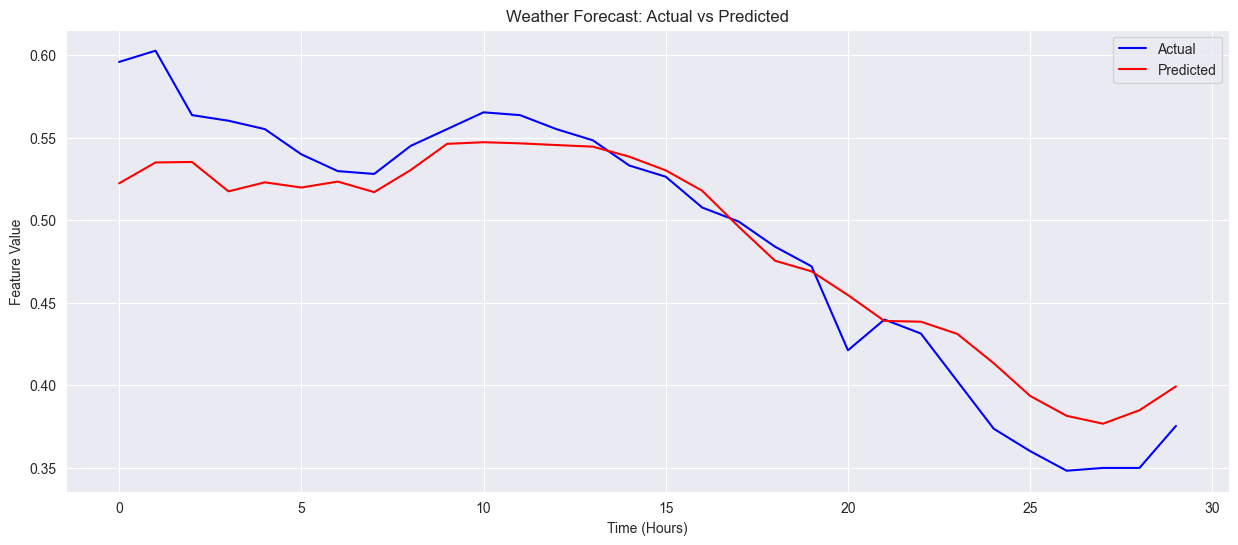

In [24]:
# Plotting
plt.figure(figsize=(15, 6))

# Assuming you want to plot the predictions for the first feature (e.g., temperature)
# Adjust the indices 0, 1, 2 for temperature, rainfall, and pressure respectively
plt.plot(y_test[300:330, 0], label='Actual', color='blue')
plt.plot(y_pred[300:330, 0], label='Predicted', color='red')

# Labeling the plot
plt.title('Weather Forecast: Actual vs Predicted')
plt.xlabel('Time (Hours)')
plt.ylabel('Feature Value')
plt.legend()

plt.show()


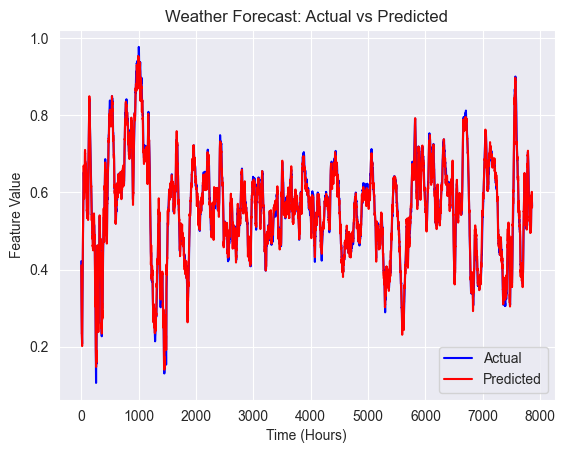

In [25]:
plt.plot(y_test[:, 1], label='Actual', color='blue')
plt.plot(y_pred[:, 1], label='Predicted', color='red')

# Labeling the plot
plt.title('Weather Forecast: Actual vs Predicted')
plt.xlabel('Time (Hours)')
plt.ylabel('Feature Value')
plt.legend()

plt.show()

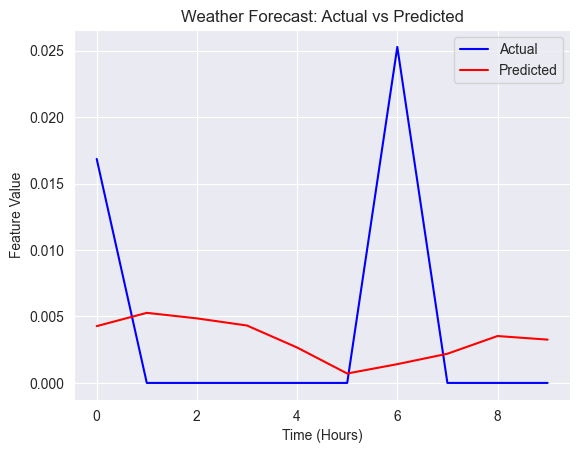

In [28]:
plt.plot(y_test[:10, 2], label='Actual', color='blue')
plt.plot(y_pred[:10, 2], label='Predicted', color='red')

# Labeling the plot
plt.title('Weather Forecast: Actual vs Predicted')
plt.xlabel('Time (Hours)')
plt.ylabel('Feature Value')
plt.legend()

plt.show()